# 04 - Clustering Results

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np

from models.X_RCC import XRCC
from models.radially_constrained_cluster import Radially_Constrained_Cluster
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_0')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

In [4]:
dataset_t2m = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/2m_temperature/temperature_1980_2011_15dd.nc').var167.load()
dataset_tp = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/total_precipitation/precipitation_1980_2011_15dd.nc').tp.load()

dataset_tp['time'] = dataset_t2m['time']

In [18]:
datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

clustering_params = {
    'iters': 100,
    'n_seas': 2,
    'learning_rate': 10,
    'min_len': 30,
    'mode': 'single',
    'starting_bp': [165, 264],
}

result = XRCC(datasets, **clustering_params)

In [19]:
def plot_seasons_bk_results(result, nrows = 1, ncolumns = None, figsize = None, cmaps = None, titles = None, lims = None):

    n_clusters = result.cluster.size

    if ncolumns is None:
        ncolumns = n_clusters

    if figsize is None:
        figsize = (5*n_clusters, 5)

    if cmaps is None:
        cmaps = ['jet'] * n_clusters

    if titles is None:
        titles = [''] * n_clusters
    
    if lims is None:
        lims = [None] * n_clusters
    
    fig, ax = plt.subplots(nrows, ncolumns, figsize = figsize)

    for j, cmap, title, lim in zip(range(n_clusters), cmaps, titles, lims):

        to_plot = result.sel(cluster=j)

        if lim is None:
            lev = np.linspace(to_plot.min(),to_plot.max(),6)
        
        else:
            lev = np.linspace(lim[0],lim[1],6)
        plot = to_plot.plot.contourf(levels=lev, add_colorbar=False, ax = ax[j], cmap=cmap)

        standard_format_single( plot,
                                country_boundary   = country_boundary,
                                # world_boundary     = world_boundary,
                                custom_cbar        = True
                                )

        plot.colorbar.set_ticks(ticks=lev, labels=[day_of_year_to_date(x) for x in lev])
        ax[j].set_title(title)

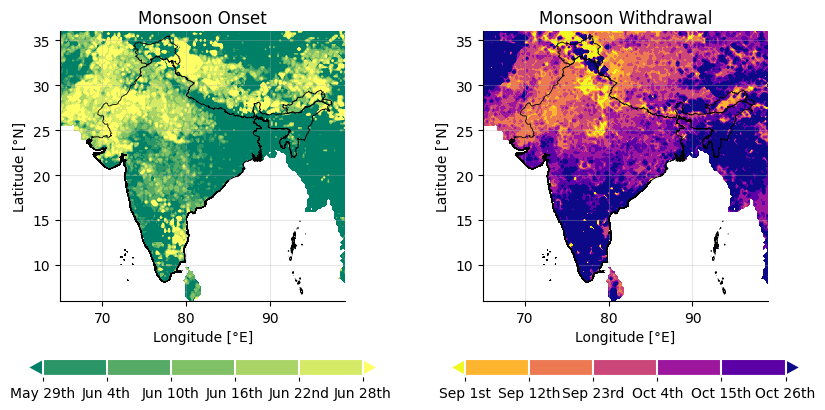

In [20]:
plot_seasons_bk_results(result, figsize=(10,5), cmaps=['summer', 'plasma_r'], lims=[[150,180],[245,300]], titles=['Monsoon Onset', 'Monsoon Withdrawal'])

In [21]:

def X_cluster_with_silhouette(*grid_points, **kwargs):
    """
    Perform clustering on multiple variables from grid points and compute silhouette score.

    Parameters:
    -----------
    *grid_points : tuple of numpy arrays
        Input grid points variables to be clustered.
    **kwargs : keyword arguments
        Additional parameters for clustering.

    Returns:
    --------
    float
        Silhouette score from clustering.
    """
    iters = kwargs.get('iters', 20)
    n_seas = kwargs.get('n_seas', 2)
    learning_rate = kwargs.get('learning_rate', 10)
    min_len = kwargs.get('min_len', 30)
    mode = kwargs.get('mode', 'single')
    starting_bp = kwargs.get('starting_bp', [165, 264])

    arrays = []
    
    for grid_points_var in grid_points:
        grid_points_var = np.asarray(grid_points_var)
        grid_points_var = np.reshape(grid_points_var, (365, int(grid_points_var.size/365)), order='F')
        
        if np.isnan(grid_points_var).any():
            return np.nan
        
        arrays.append(grid_points_var)
    
    combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)
    
    normalized_arrays = []
    for arr in arrays:
        array_tot = arr[:, combined_mask]
        array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)
        normalized_arrays.append(array_tot)
    
    array_tot = np.concatenate(normalized_arrays, axis=1)

    # Initialize and fit the Radially_Constrained_Cluster model
    model = Radially_Constrained_Cluster(data_to_cluster=array_tot,
                                         n_seas=n_seas,
                                         n_iter=iters,
                                         learning_rate=learning_rate,
                                         min_len=min_len,
                                         mode=mode,
                                         starting_bp=starting_bp)
    model.fit()
    labels = model.get_prediction()

    try:
        # Calculate the silhouette score
        silhouette_avg = silhouette_score(array_tot, labels)
        return silhouette_avg

    except:
        return np.nan

def XRCC_silhouette_mod(datasets, **kwargs):
    """
    Apply clustering function to a list of xarray DataArrays and compute silhouette scores.

    Parameters:
    -----------
    datasets : list of xarray DataArrays
        Input datasets to be clustered.
    **kwargs : keyword arguments
        Additional parameters for clustering.

    Returns:
    --------
    xarray.DataArray
        Silhouette scores for each point grid.
    """
    result = xr.apply_ufunc(
        X_cluster_with_silhouette,
        *datasets,
        kwargs=kwargs,
        input_core_dims=[['time']] * len(datasets),
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

    return result

In [22]:
# datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

# clustering_params = {
#     'iters': 2,
#     'n_seas': 2,
#     'learning_rate': 10,
#     'min_len': 30,
#     'mode': 'single',
#     'starting_bp': [165, 264],
# }

# result = XRCC_silhouette_mod(datasets, **clustering_params)

In [23]:
datasets = [dataset_tp, dataset_t2m]  # List of xarray DataArrays

tot = []
for j, st in zip([2,4], [[165, 264],[80, 165, 264, 300]]):
    clustering_params = {
        'iters': 100,
        'learning_rate': 10,
        'min_len': 30,
        'mode': 'single',
        'starting_bp': st,  # Optional, if starting_bp is used
        'n_seas' : j
    }

    silhouette_scores = XRCC_silhouette_mod(datasets, **clustering_params)
    tot.append(silhouette_scores.assign_coords(n_seasons=j))

tota = xr.concat(tot, dim='n_seasons')


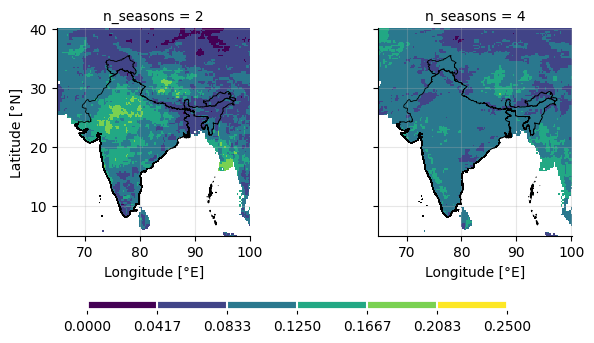

In [ ]:
plot = tota.plot(col='n_seasons', col_wrap=2, vmin=0, vmax=0.25, levels=7, add_colorbar=False, figsize=(10,5))

standard_format( plot,
                 country_boundary   = country_boundary,
                 # world_boundary     = world_boundary,
                 custom_cbar        = True
                )

In [ ]:
combined_data_array_filled = tota.fillna(-np.inf)
max_n_seasons_idx = combined_data_array_filled.argmax(dim='n_seasons')
max_n_seasons = tota['n_seasons'][max_n_seasons_idx]

# Crea un mask per individuare dove entrambi i n_seasons sono NaN
nan_mask = np.isnan(tota.sel(n_seasons=2)) & np.isnan(tota.sel(n_seasons=4))

# Rimuovere i NaN dai risultati finali usando il mask
max_n_seasons = max_n_seasons.where(~nan_mask)

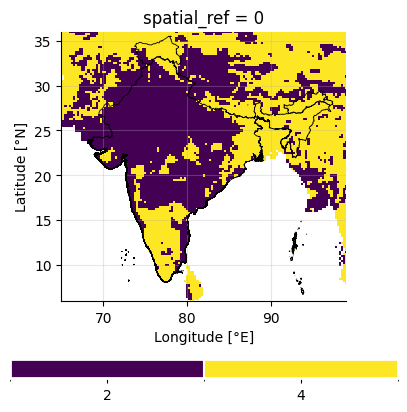

In [ ]:
plot = max_n_seasons.plot(vmin=1, vmax=5, levels=3, add_colorbar=False, figsize=(5,5))

standard_format_single( plot,
                        country_boundary   = country_boundary,
                        # world_boundary     = world_boundary,
                        custom_cbar        = True
                        )
plot.colorbar.set_ticks(ticks=[2,4], labels=[2,4])